# Melanoma inference kernel by [@shonenkov](https://www.kaggle.com/shonenkov)

# Main Idea:

Inference for single model

# Dependencies

In [23]:
!pip install -q efficientnet_pytorch > /dev/null

In [24]:
from glob import glob
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import GroupKFold
import cv2
from skimage import io
import albumentations as A
import scipy as sp
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn import functional as F
from glob import glob
import sklearn
from torch import nn
import warnings

warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# External data

I have prepared [kernel with merging data](https://www.kaggle.com/shonenkov/merge-external-data). Don't forget to read this kernel ;)

In [25]:
DATA_PATH = '../input/melanoma-merged-external-data-512x512-jpeg'

In [26]:
TEST_ROOT_PATH = f'{DATA_PATH}/512x512-test/512x512-test'

def get_valid_transforms():
    return  A.Compose([
           A.Resize(image_size, image_size),
    A.Normalize(),
    ToTensorV2(p=1.0),                  

        ])

# class DatasetRetriever(Dataset):

#     def __init__(self, image_ids, transforms=None):
#         super().__init__()
#         self.image_ids = image_ids
#         self.transforms = transforms

#     def __getitem__(self, idx: int):
#         image_id = self.image_ids[idx]
#         image = cv2.imread(f'{TEST_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
#         image = image.astype(np.float32) / 255.0
#         if self.transforms:
#             sample = {'image': image}
#             sample = self.transforms(**sample)
#             image = sample['image']
#         return image, image_id

#     def __len__(self) -> int:
#         return self.image_ids.shape[0]

class DatasetRetriever(Dataset):

    def __init__(self,df: pd.DataFrame, image_ids, transforms=None,meta_features=None):
            super().__init__()
            self.image_ids = image_ids
    #         self.labels = labels
            self.transforms = transforms
            self.df = df
    #         self.train = train
            self.meta_features = meta_features


    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        image = cv2.imread(f'{TEST_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = image.astype(np.float32) / 255.0

#         label = self.labels[idx]

        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']

#         target = onehot(2, label)


        meta = np.array(self.df.loc[self.df['image_name'] == image_id][self.meta_features].values, dtype=np.float32)
#         print(meta.shape)

        return  (image, meta) ,image_id
    def __len__(self) -> int:
        return self.image_ids.shape[0]


In [27]:
from efficientnet_pytorch import EfficientNet

def get_net():
    net = EfficientNet.from_name('efficientnet-b5')
    net._fc = nn.Linear(in_features=2048, out_features=2, bias=True)
    return net

net = get_net().cuda()

In [28]:
train_df = pd.read_csv('/kaggle/input/melanoma-merged-external-data-512x512-jpeg/folds.csv')
test_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
# isic_train_df = pd.read_csv('/kaggle/input/jpeg-isic2019-512x512//train.csv')

# Concatenate the two datasets for training
# train_df = pd.concat([train_df, isic_train_df], axis=0, ignore_index=True)

# One-hot encoding of anatom_site_general_challenge feature
concat = pd.concat([train_df['anatom_site_general_challenge'], test_df['anatom_site_general_challenge']], ignore_index=True)
dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
train_df = pd.concat([train_df, dummies.iloc[:train_df.shape[0]]], axis=1)
test_df = pd.concat([test_df, dummies.iloc[train_df.shape[0]:].reset_index(drop=True)], axis=1)

# Sex features
train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})
train_df['sex'] = train_df['sex'].fillna(-1)
test_df['sex'] = test_df['sex'].fillna(-1)

# Age features
train_df['age_approx'] /= train_df['age_approx'].max()
test_df['age_approx'] /= test_df['age_approx'].max()
train_df['age_approx'] = train_df['age_approx'].fillna(0)
test_df['age_approx'] = test_df['age_approx'].fillna(0)

train_df['patient_id'] = train_df['patient_id'].fillna(0)
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

In [29]:
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        elif 'EfficientNet' in str(arch.__class__):
            
            
            
#             net = EfficientNet.from_pretrained('efficientnet-b5')
#             net._fc = nn.Linear(in_features=2048, out_features=2, bias=True)
            self.arch._fc = nn.Linear(in_features=2048, out_features=500, bias=True)
        elif 'Xception' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=2048, out_features=500, bias=True)  # Xception typically has 2048 features
        
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 250 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 2)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
#         print(meta.shape)
        
        
        cnn_features = self.arch(x)
#         print(cnn_features.shape)
        meta_features = self.meta(meta.squeeze())
#         print(meta_features.shape)
        features = torch.cat((cnn_features, meta_features), dim=1)
#         for i, dropout in enumerate(self.dropouts):
#             if i == 0:
#                 out = self.ouput(dropout(x))
#             else:
#                 out += self.ouput(dropout(x))
        output = self.ouput(features)
#         out /= len(self.dropouts)
        return output


from efficientnet_pytorch import EfficientNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

arch = EfficientNet.from_pretrained('efficientnet-b5')
net = Net(arch=arch, n_meta_features=len(meta_features))  # Initialize model
net = net.to(device)

Loaded pretrained weights for efficientnet-b5


In [30]:
!pip install timm


In [31]:
# import timm  # Import timm for loading Xception

# arch = timm.create_model('xception', pretrained=True)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# net = Net(arch=arch, n_meta_features=len(meta_features))  # Initialize model
# net = net.to(device)

In [32]:
df_test = pd.read_csv(f'../input/siim-isic-melanoma-classification/test.csv', index_col='image_name')
image_size=512

test_dataset = DatasetRetriever(
        df=test_df,

    image_ids=df_test.index.values,
    transforms=get_valid_transforms(),
    meta_features=meta_features
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=8,
    num_workers=2,
    shuffle=False,
    sampler=SequentialSampler(test_dataset),
    pin_memory=False,
    drop_last=False,
)

In [33]:
checkpoint_path = '/kaggle/input/exffeccint_with_advanced_augmentation/pytorch/default/1/best-score-checkpoint-017epoch.bin'
checkpoint = torch.load(checkpoint_path)
net.load_state_dict(checkpoint);
net.eval();

In [34]:
result = {'image_name': [], 'target': []}
for data, image_names in tqdm(test_loader, total=len(test_loader)):
    with torch.no_grad():
        data[0] = data[0].to(device).float()
        data[1] = data[1].to(device).float() 
#         images = images.cuda().float()
        outputs = net(data)
        y_pred = nn.functional.softmax(outputs, dim=1).data.cpu().numpy()[:,1]

    result['image_name'].extend(image_names)
    result['target'].extend(y_pred)

submission = pd.DataFrame(result)

100%|██████████| 1373/1373 [03:39<00:00,  6.26it/s]


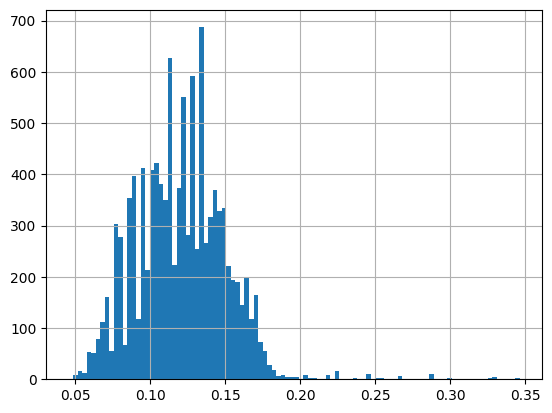

In [35]:
submission.to_csv('submission.csv', index=False)
submission['target'].hist(bins=100);

# Thank you for reading my kernel

Don't forget to read my other kernels about this competition:

- [[Training CV] Melanoma Starter](https://www.kaggle.com/shonenkov/training-cv-melanoma-starter)
- [[Merge External Data]](https://www.kaggle.com/shonenkov/merge-external-data)